In [12]:
# 코랩에서 한글 사용(# 나눔 한글 폰트 설치)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [39]:
import tensorflow as tf
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import keras
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.isnull().sum()

일자                0
요일                0
본사정원수             0
본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
조식메뉴              0
중식메뉴              0
석식메뉴              0
중식계               0
석식계               0
dtype: int64

In [4]:
def process_text(text):
  # 괄호 안의 내용 제거
  processed_text = re.sub(r"\([^)]*\)", " ", text)
  # 한글 및 영문, 숫자만 남기고 나머지 제거
  processed_text = re.sub(r"[^A-Za-z가-힣0-9]", " ", processed_text)
  return processed_text

In [5]:
train['조식메뉴'] = train['조식메뉴'].apply(process_text)
train['중식메뉴'] = train['중식메뉴'].apply(process_text)
train['석식메뉴'] = train['석식메뉴'].apply(process_text)

In [7]:
food_list = train[['조식메뉴', '중식메뉴', '석식메뉴']].values.flatten().tolist()

In [8]:
food_list2 = []

for food in food_list:
  food = re.sub(r'\s+', ' ', food)
  food_list2.append(food.split(" "))

In [9]:
food_list2 = sum(food_list2, [])

In [10]:
from collections import Counter

# counter를 이용해 각 단어의 개수.
counter = Counter(food_list2)

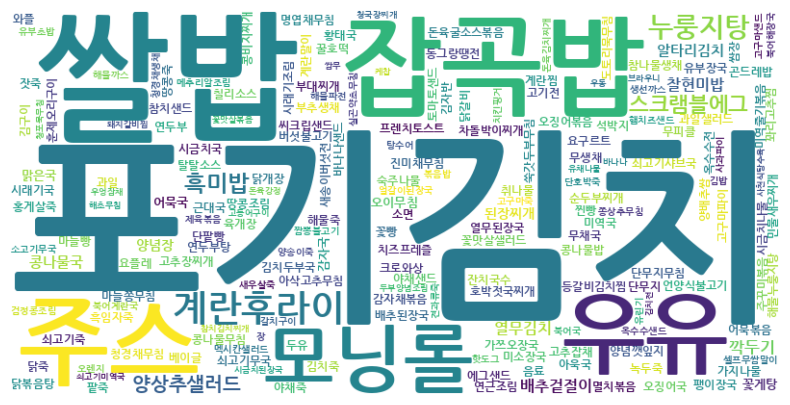

In [17]:
# 워드 클라우드 그려보기
from wordcloud import WordCloud

# 리스트를 튜플로 변환하여 set에 넣어 중복 제거
unique_tuples = {tuple(sublist) for sublist in food_list2}

# 다시 리스트로 변환
unique_lists = [list(t) for t in unique_tuples]

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud 객체 생성
wordcloud = WordCloud(width=800, height=400, font_path='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
                      background_color='white').generate_from_frequencies(counter)

# 워드 클라우드를 그림
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 숨김
plt.show()

In [23]:
# 자주 나오는 상위 20개 음식 뽑아보기
top_food = dict(counter.most_common(20))
top_food

{'': 3676,
 '포기김치': 2961,
 '쌀밥': 2744,
 '잡곡밥': 1536,
 '주스': 1211,
 '우유': 1205,
 '모닝롤': 1200,
 '계란후라이': 940,
 '누룽지탕': 426,
 '흑미밥': 291,
 '스크램블에그': 241,
 '양상추샐러드': 202,
 '깍두기': 148,
 '배추겉절이': 131,
 '열무김치': 123,
 '찰현미밥': 118,
 '콩나물국': 103,
 '알타리김치': 99,
 '된장찌개': 90,
 '양념장': 90}

In [24]:
stopwords = ['쌀밥', '잡곡밥', '우유', '주스', '포기김치', '찐계란', '흑미밥' ,
             '모닝롤', '쌈추', '깻잎', '누룽지', '계란후라이', '스크램블에그',
             '양상추샐러드', '깍두기', '배추겉절이', '찰현미밥', '콩나물국', '알타리김치',
             '된장찌개', '양념장', '숙주나물', '단무지', '단무지무침', '명엽채무침',
             '시래기조림', '음료']

### 새로운 파생변수

In [25]:
train['본사출근자수'] = train['본사정원수'] - (train['본사출장자수'] + train['본사휴가자수'] + train['현본사소속재택근무자수'])
train['본사출근자수']

0       2401.0
1       2378.0
2       2365.0
3       2277.0
4       2142.0
         ...  
1200    2319.0
1201    2309.0
1202    2177.0
1203    2396.0
1204    2369.0
Name: 본사출근자수, Length: 1205, dtype: float64

### 워드 임베딩

In [27]:
df_all = pd.concat([train, test])

In [28]:
# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [29]:
# Get all combinations for training w2v (train + test)

food_combinations = []
for i in ['조식메뉴', '중식메뉴', '석식메뉴']:
    food_combinations += df_all[i].apply(lambda x: split_process(x, i)).to_list()

In [32]:
# Train or load w2v model

# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
        model.save('food_embedding.model')
    else:
        print("Model loading failed. Do not train.")

Training w2v


In [34]:
# w2v demo
model.wv.most_similar('훈제오리구이')

[('버섯불고기', 0.46815329790115356),
 ('파채상추무침', 0.4324329197406769),
 ('완자전', 0.42591914534568787),
 ('파채', 0.41365766525268555),
 ('오징어볶음', 0.404619961977005),
 ('삼겹살오븐구이', 0.4042262136936188),
 ('닭갈비', 0.4029805660247803),
 ('오징어돈육볶음', 0.3920523226261139),
 ('돈삼겹보쌈', 0.39172616600990295),
 ('돈육간장볶음', 0.39157629013061523)]

In [36]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

def preprocess_date(df, is_train):
    if is_train:
        df = df[df['석식계'] > 0]

    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day

    day_encoder = LabelEncoder()
    df['요일'] = day_encoder.fit_transform(df['요일'])
    df['remains'] = df['본사정원수'] - df['본사휴가자수'] - df['본사출장자수'] - df['현본사소속재택근무자수']
    df['dinner'] = df['석식메뉴'].apply(lambda x: get_food_embedding(x))

    if is_train:
        y = df['석식계']
    else:
        y = 0

    df.drop(['일자','조식메뉴', '중식메뉴', '석식메뉴', '본사정원수', '본사휴가자수', '본사출장자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수'], axis=1, inplace=True)
    if is_train:
        df.drop(['중식계', '석식계'], axis=1, inplace=True)

    common = df.iloc[:, :4].to_numpy()
    dinner = np.expand_dims(np.array(df.iloc[:, 4].to_numpy().tolist()), axis=1)
    common = np.concatenate((df.iloc[:, :4].to_numpy(), dinner), axis=1)

    return common, y


In [40]:
x_train, y_train = preprocess_date(train, True)
x_test, _ = preprocess_date(test, False)

<ipython-input-36-8f9027b55893>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
<ipython-input-36-8f9027b55893>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['일자'].dt.year
<ipython-input-36-8f9027b55893>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [41]:
input_train, input_val, target_train, target_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

### 모델링

In [42]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(input_train, target_train)
pred = model.predict(input_val)
print("dinner mae: ", mean_absolute_error(pred, target_val))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1045, number of used features: 5
[LightGBM] [Info] Start training from score 480.212440
dinner mae:  46.689918051640134


In [44]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# scaling
svr = SVR()
svr.fit(input_train, target_train)
pred2 = svr.predict(input_val)
print("SVR dinner mae: ", mean_absolute_error(pred2, target_val))

tree = DecisionTreeRegressor()
tree.fit(input_train, target_train)
pred3 = tree.predict(input_val)
print("DecisionTree dinner mae: ", mean_absolute_error(pred3, target_val))

SVR dinner mae:  82.02682765773095
DecisionTree dinner mae:  61.63247863247863


In [48]:
# 앙상블
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [16, 20, 24, 28, 32], 'min_samples_leaf': [1, 2, 3, 4],
          'min_samples_split': [4, 8, 16, 24]}

reg = RandomForestRegressor(n_estimators=100)
grid_reg = GridSearchCV(reg, param_grid=params, cv=2, n_jobs=-1)  # -1 은 cpu를 다 쓴다는 의미
grid_reg.fit(input_train, target_train)

print(f"최적의 파라미터\n{grid_reg.best_params_}")
print(f"최고 정확도: {grid_reg.best_score_}")

최적의 파라미터
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 400}
최고 정확도: 0.49943600744292554


In [49]:
pred3 = grid_reg.predict(input_val)
print("RandomForest: ", mean_squared_error(target_val, pred))

RandomForest:  9249.059829059828


In [47]:
from sklearn.ensemble import VotingRegressor
house_voting = VotingRegressor(estimators=[("SVR", svr), ("DecisionTree", tree)])

regressors = [house_voting, svr, tree]
for regressor in regressors:
    regressor.fit(input_train, target_train)
    pred = regressor.predict(input_val)
    name = regressor.__class__.__name__
    print(f"{name}'s MSE : {mean_squared_error(target_val, pred)}")

VotingRegressor's MSE : 6487.333499747507
SVR's MSE : 11238.478728004415
DecisionTreeRegressor's MSE : 9249.059829059828
